在上一章的三个例子（预测电影评论、主题分类和房价回归）中，模型在留出验证数据上的性能总是在几轮后达到最高点，然后开始下降。也就是说，模型很快就在训练数据上开始过拟合。过拟合存在于所有机器学习问题中。学会如何处理过拟合对掌握机器学习至关重要。  

机器学习的根本问题是优化和泛化之间的对立。优化（optimization）是指调节模型以在训练数据上得到最佳性能（即机器学习中的学习），而泛化（generalization）是指训练好的模型在前所未见的数据上的性能好坏。机器学习的目的当然是得到良好的泛化，但你无法控制泛化，只能基于训练数据调节模型。  

训练开始时，优化和泛化是相关的：训练数据上的损失越小，测试数据上的损失也越小。这时的模型是欠拟合（underfit）的，即仍有改进的空间，网络还没有对训练数据中所有相关模式建模。但在训练数据上迭代一定次数之后，泛化不再提高，验证指标先是不变，然后开始变差，即模型开始过拟合。这时模型开始学习仅和训练数据有关的模式，但这种模式对新数据来说是错误的或无关紧要的。  

为了防止模型从训练数据中学到错误或无关紧要的模式，最优解决方法是获取更多的训练数据。模型的训练数据越多，泛化能力自然也越好。如果无法获取更多数据，次优解决方法是调节模型允许存储的信息量，或对模型允许存储的信息加以约束。如果一个网络只能记住几个模式，那么优化过程会迫使模型集中学习最重要的模式，这样更可能得到良好的泛化。  

这种降低过拟合的方法叫作正则化（regularization）。我们先介绍几种最常见的正则化方法，然后将其应用于实践中，以改进 3.4节的电影分类模型。

### 4.4.1　减小网络大小
防止过拟合的最简单的方法就是减小模型大小，即减少模型中可学习参数的个数（这由层数和每层的单元个数决定）。在深度学习中，模型中可学习参数的个数通常被称为模型的容量（capacity）。直观上来看，参数更多的模型拥有更大的记忆容量（memorization capacity），因此能够在训练样本和目标之间轻松地学会完美的字典式映射，这种映射没有任何泛化能力。例如，拥有 500,000个二进制参数的模型，能够轻松学会MNIST训练集中所有数字对应的类别——我们只需让50,000个数字每个都对应10个二进制参数。但这种模型对于新数字样本的分类毫无用处。始终牢记：深度学习模型通常都很擅长拟合训练数据，但真正的挑战在于泛化，而不是拟合。  

与此相反，如果网络的记忆资源有限，则无法轻松学会这种映射。因此，为了让损失最小化，网络必须学会对目标具有很强预测能力的压缩表示，这也正是我们感兴趣的数据表示。同时请记住，你使用的模型应该具有足够多的参数，以防欠拟合，即模型应避免记忆资源不足。在容量过大与容量不足之间要找到一个折中。   

要找到合适的模型大小，一般的工作流程是开始时选择相对较少的层和参数，然后逐渐增加层的大小或增加新层，直到这种增加对验证损失的影响变得很小。

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/yihuawang/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprec

In [3]:
word_index = imdb.get_word_index() # word_index是一个将单词映射为整数索引的字典

reverse_word_index = dict( # 字典功能 
    [(value, key) for (key, value) in word_index.items()]) # 键值颠倒，将整数索引映射为单词

decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]) # 对train_data[0]中的各个i, 利用reverse_word_index进行映射
# 减去3是因为 0对应 padding; 2对应 start of sequence; 3对应 unknown. 它们通通被映射为?

In [4]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000): # 取10,000是因为我们之前限定了10,000个最常见的单词，因此单词索引不会超过10,000
    # 以train_data[0]为例子
    results = np.zeros((len(sequences), dimension)) #产生一个 218* 10,000的矩阵
    for i, sequence in enumerate(sequences): #enumerate() 会产生[(0, 1),(1, 14),...,(217, 32)], 
                                             #前一个数字代表position, 后一个数字代表单词索引
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [5]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [10]:
# 原始模型
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,))) # hidden unit=16
model.add(layers.Dense(16, activation='relu')) #hidden unit=16
model.add(layers.Dense(1, activation='sigmoid')) # hidden unit=1

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history.orignal = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, # 模型训练20轮次
                    batch_size=512, #batch_size 批量大小，即一次训练所选取的样本数，512个样本促成的小批量
                    validation_data=(x_val, y_val)) #将验证数据传入validation_data 来监控损失和精度

Epoch 1/20
30/30 [==============================] - 2s 35ms/step - loss: 0.5732 - accuracy: 0.7204 - val_loss: 0.3669 - val_accuracy: 0.8669
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2956 - accuracy: 0.9111 - val_loss: 0.3045 - val_accuracy: 0.8825
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2136 - accuracy: 0.9333 - val_loss: 0.3351 - val_accuracy: 0.8608
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1707 - accuracy: 0.9433 - val_loss: 0.3037 - val_accuracy: 0.8785
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1348 - accuracy: 0.9595 - val_loss: 0.2826 - val_accuracy: 0.8876
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1075 - accuracy: 0.9695 - val_loss: 0.3255 - val_accuracy: 0.8792
Epoch 7/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0931 - accuracy: 0.9738 - val_loss: 0.3313 - val_accuracy: 0.8771
Epoch 8/20
30

In [12]:
# 容量更小的模型
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(10000,))) # hidden unit=16
model.add(layers.Dense(4, activation='relu')) #hidden unit=16
model.add(layers.Dense(1, activation='sigmoid')) # hidden unit=1

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history.smaller = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, # 模型训练20轮次
                    batch_size=512, #batch_size 批量大小，即一次训练所选取的样本数，512个样本促成的小批量
                    validation_data=(x_val, y_val)) #将验证数据传入validation_data 来监控损失和精度

Epoch 1/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6446 - accuracy: 0.6586 - val_loss: 0.5200 - val_accuracy: 0.8360
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.4717 - accuracy: 0.8758 - val_loss: 0.4252 - val_accuracy: 0.8620
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3775 - accuracy: 0.8937 - val_loss: 0.3648 - val_accuracy: 0.8779
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3078 - accuracy: 0.9142 - val_loss: 0.3246 - val_accuracy: 0.8832
Epoch 5/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2561 - accuracy: 0.9265 - val_loss: 0.3032 - val_accuracy: 0.8847
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2200 - accuracy: 0.9358 - val_loss: 0.2846 - val_accuracy: 0.8906
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1935 - accuracy: 0.9423 - val_loss: 0.2804 - val_accuracy: 0.8890
Epoch 8/20
30

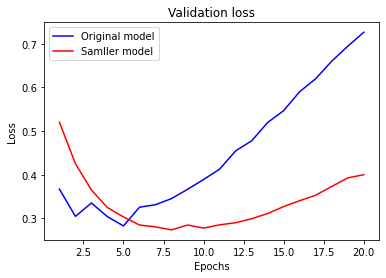

In [14]:
# 画图 Plotting the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.orignal.history
val_loss_values = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

history_dict = history.smaller.history
val_loss_values_smaller = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

epochs = range(1, len(loss_values) + 1) # x axis
plt.plot(epochs, val_loss_values, "b", label="Original model")
plt.plot(epochs, val_loss_values_smaller, "b",color="red", label="Samller model")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 请记住，更小的验证损失对应更好的模型,这里反而是小模型效果更好

In [15]:
# 容量更大的模型
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(10000,))) # hidden unit=16
model.add(layers.Dense(512, activation='relu')) #hidden unit=16
model.add(layers.Dense(1, activation='sigmoid')) # hidden unit=1

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history.bigger = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, # 模型训练20轮次
                    batch_size=512, #batch_size 批量大小，即一次训练所选取的样本数，512个样本促成的小批量
                    validation_data=(x_val, y_val)) #将验证数据传入validation_data 来监控损失和精度

Epoch 1/20
30/30 [==============================] - 5s 133ms/step - loss: 0.6812 - accuracy: 0.6831 - val_loss: 0.3371 - val_accuracy: 0.8577
Epoch 2/20
30/30 [==============================] - 3s 105ms/step - loss: 0.2710 - accuracy: 0.8942 - val_loss: 0.3172 - val_accuracy: 0.8664
Epoch 3/20
30/30 [==============================] - 3s 100ms/step - loss: 0.1450 - accuracy: 0.9463 - val_loss: 0.2844 - val_accuracy: 0.8911
Epoch 4/20
30/30 [==============================] - 3s 90ms/step - loss: 0.0605 - accuracy: 0.9793 - val_loss: 0.3624 - val_accuracy: 0.8635
Epoch 5/20
30/30 [==============================] - 3s 104ms/step - loss: 0.0202 - accuracy: 0.9964 - val_loss: 1.2949 - val_accuracy: 0.7357
Epoch 6/20
30/30 [==============================] - 3s 85ms/step - loss: 0.0770 - accuracy: 0.9710 - val_loss: 0.5332 - val_accuracy: 0.8883
Epoch 7/20
30/30 [==============================] - 3s 88ms/step - loss: 6.5205e-04 - accuracy: 0.9997 - val_loss: 0.6217 - val_accuracy: 0.8885
Epoch

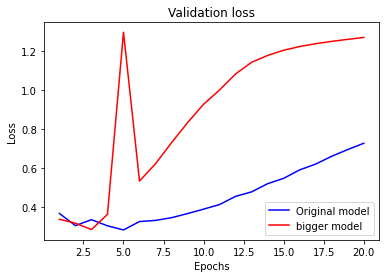

In [16]:
# 画图 Plotting the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.orignal.history
val_loss_values = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

history_dict = history.bigger.history
val_loss_values_bigger = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

epochs = range(1, len(loss_values) + 1) # x axis
plt.plot(epochs, val_loss_values, "b", label="Original model")
plt.plot(epochs, val_loss_values_bigger, "b",color="red", label="bigger model")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 请记住，更小的验证损失对应更好的模型,这里大模型马上就显示出过拟合

### 4.4.2　添加权重正则化
奥卡姆剃刀（Occam’s  razor）原理：如果一件事情有两种解释，那么最可能正确的解释就是最简单的那个，即假设更少的那个。  

这个原理也适用于神经网络学到的模型：给定一些训练数据和一种网络架构，很多组权重值（即很多模型）都可以解释这些数据。  

但简单模型比复杂模型更不容易过拟合。

这里的简单模型（simple model）是指参数值分布的熵更小的模型（或参数更少的模型，比如上一节的例子）。   

因此，一种常见的降低过拟合的方法就是强制让模型权重只能取较小的值，从而限制模型的复杂度，这使得权重值的分布更加规则（regular）。这种方法叫作权重正则化（weight regularization），其实现方法是向网络损失函数中添加与较大权重值相关的成本（cost）。这个成本有两种形式。  

1. L1正则化（L1  regularization）：添加的成本与权重系数的绝对值［权重的 L1范数（norm）］成正比。
2. L2正则化（L2  regularization）：添加的成本与权重系数的平方（权重的 L2范数）成正比。神经网络的 L2正则化也叫权重衰减（weight  decay）。不要被不同的名称搞混，权重衰减与 L2正则化在数学上是完全相同的。

In [21]:
# l2(0.001)的意思是该层权重矩阵的每个系数都会使网络总损失增加0.001 * weight_coefficient_value。
# 注意，由于这个惩罚项只在训练时添加，所以这个网络的训练损失会比测试损失大很多。
model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),#
        activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
        activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history.L2 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, # 模型训练20轮次
                    batch_size=512, #batch_size 批量大小，即一次训练所选取的样本数，512个样本促成的小批量
                    validation_data=(x_val, y_val)) #将验证数据传入validation_data 来监控损失和精度

Epoch 1/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6479 - accuracy: 0.7056 - val_loss: 0.4434 - val_accuracy: 0.8698
Epoch 2/20
30/30 [==============================] - 0s 17ms/step - loss: 0.3854 - accuracy: 0.8964 - val_loss: 0.3819 - val_accuracy: 0.8641
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2988 - accuracy: 0.9197 - val_loss: 0.3367 - val_accuracy: 0.8897
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2578 - accuracy: 0.9349 - val_loss: 0.3353 - val_accuracy: 0.8860
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2370 - accuracy: 0.9421 - val_loss: 0.3381 - val_accuracy: 0.8860
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2175 - accuracy: 0.9492 - val_loss: 0.3492 - val_accuracy: 0.8844
Epoch 7/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2138 - accuracy: 0.9493 - val_loss: 0.3671 - val_accuracy: 0.8797
Epoch 8/20
30

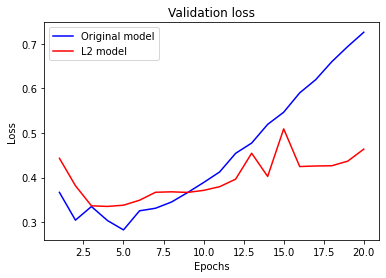

In [22]:
# 画图 Plotting the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.orignal.history
val_loss_values = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

history_dict = history.L2.history
val_loss_values_L2 = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

epochs = range(1, len(loss_values) + 1) # x axis
plt.plot(epochs, val_loss_values, "b", label="Original model")
plt.plot(epochs, val_loss_values_L2, "b",color="red", label="L2 model")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
#L2正则化惩罚的影响。如你所见，即使两个模型的参数个数相同，具有 L2正则化的模型（圆点）比参考模型（十字）更不容易过拟合

In [24]:
#L2+smaller model
model = models.Sequential()
model.add(layers.Dense(4, kernel_regularizer=regularizers.l2(0.001),#
        activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, kernel_regularizer=regularizers.l2(0.001),
        activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history.L2.smaller = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, # 模型训练20轮次
                    batch_size=512, #batch_size 批量大小，即一次训练所选取的样本数，512个样本促成的小批量
                    validation_data=(x_val, y_val)) #将验证数据传入validation_data 来监控损失和精度

Epoch 1/20
30/30 [==============================] - 1s 33ms/step - loss: 0.6662 - accuracy: 0.5969 - val_loss: 0.5672 - val_accuracy: 0.7255
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.5350 - accuracy: 0.7812 - val_loss: 0.5297 - val_accuracy: 0.7611
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.4849 - accuracy: 0.8530 - val_loss: 0.5163 - val_accuracy: 0.7936
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.4568 - accuracy: 0.8893 - val_loss: 0.5135 - val_accuracy: 0.8102
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.4348 - accuracy: 0.9110 - val_loss: 0.4890 - val_accuracy: 0.8803
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.4203 - accuracy: 0.9321 - val_loss: 0.5101 - val_accuracy: 0.8319
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.4019 - accuracy: 0.9355 - val_loss: 0.4785 - val_accuracy: 0.8778
Epoch 8/20
30

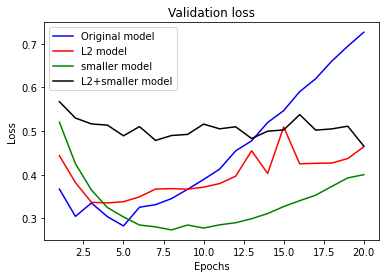

In [26]:
# 画图 Plotting the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.orignal.history
val_loss_values = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

history_dict = history.L2.history
val_loss_values_L2 = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

history_dict = history.smaller.history
val_loss_values_smaller = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

history_dict = history.L2.smaller.history
val_loss_values_L2_smaller = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

epochs = range(1, len(loss_values) + 1) # x axis
plt.plot(epochs, val_loss_values, "b", label="Original model")
plt.plot(epochs, val_loss_values_L2, "b",color="red", label="L2 model")
plt.plot(epochs, val_loss_values_smaller, "b",color="green", label="smaller model")
plt.plot(epochs, val_loss_values_L2_smaller, "b",color="black", label="L2+smaller model")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 加了L2导致最开始的loss收敛变慢了

In [ ]:
model.add(layers.Dense(4, kernel_regularizer=regularizers.l1(0.001),#L1正则化
        activation='relu', input_shape=(10000,)))

model.add(layers.Dense(4, kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001),#L1,L2同时正则化
        activation='relu', input_shape=(10000,)))

### 4.4.3　添加 dropout正则化
dropout是神经网络最有效也最常用的正则化方法之一，它是由多伦多大学的  Geoffrey Hinton和他的学生开发的。对某一层使用dropout，就是在训练过程中随机将该层的一些输出特征舍弃（设置为0）。  

假设在训练过程中，某一层对给定输入样本的返回值应该是向量[0.2,  0.5,1.3, 0.8,  1.1]。使用 dropout后，这个向量会有几个随机的元素变成     0，比如 [0, 0.5,1.3, 0,  1.1]。  

dropout比率(dropout rate)是被设为0的特征所占的比例，通常在0.2~0.5范围内。  

测试时没有单元被舍弃，而该层的输出值需要按 dropout比率缩小，因为这时比训练时有更多的单元被激活，需要加以平衡。

In [ ]:
# 假设有一个包含某层输出的Numpy矩阵 layer_output，其形状为(batch_size,features)。训练时，我们随机将矩阵中一部分值设为 0。

# np.random.randint: 返回一个随机整型数,范围从低（包括）到高（不包括, 该例子就是随机产生 0/1
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) #训练时，舍弃50% 的输出单元 

# 测试时，我们将输出按 dropout比率缩小。这里我们乘以 0.5（因为前面舍弃了一半的单元）。
layer_output *= 0.5


# 注意，为了实现这一过程，还可以让两个运算都在训练时进行，而测试时输出保持不变。这通常也是实践中的实现方式（见图 4-8）。
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)
layer_output /= 0.5 #成比例放大


In [33]:
np.random.randint(0, high=2, size=10)

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1])

#### 它为什么能够降低过拟合？  
Hinton说他的灵感之一来自于银行的防欺诈机制。用他自己的话来说：“我去银行办理业务。柜员不停地换人，于是我问其中一人这是为什么。他说他不知道，但他们经常换来换去。我猜想，银行工作人员要想成功欺诈银行，他们之间要互相合作才行。这让我意识到，在每个样本中随机删除不同的部分神经元，可以阻止它们的阴谋，因此可以降低过拟合。”其核心思想是在层的输出值中引入噪声，打破不显著的偶然模式（Hinton称之为阴谋）。如果没有噪声的话，网络将会记住这些偶然模式。



In [34]:
# Dropout model
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history.dropout = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, # 模型训练20轮次
                    batch_size=512, #batch_size 批量大小，即一次训练所选取的样本数，512个样本促成的小批量
                    validation_data=(x_val, y_val)) #将验证数据传入validation_data 来监控损失和精度


Epoch 1/20
30/30 [==============================] - 3s 67ms/step - loss: 0.6732 - accuracy: 0.5657 - val_loss: 0.5362 - val_accuracy: 0.8407
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.5445 - accuracy: 0.7298 - val_loss: 0.4239 - val_accuracy: 0.8688
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.4464 - accuracy: 0.8117 - val_loss: 0.3572 - val_accuracy: 0.8688
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3756 - accuracy: 0.8487 - val_loss: 0.3184 - val_accuracy: 0.8775
Epoch 5/20
30/30 [==============================] - 0s 17ms/step - loss: 0.3313 - accuracy: 0.8792 - val_loss: 0.2895 - val_accuracy: 0.8912
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2751 - accuracy: 0.9076 - val_loss: 0.2738 - val_accuracy: 0.8921
Epoch 7/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2480 - accuracy: 0.9206 - val_loss: 0.2977 - val_accuracy: 0.8858
Epoch 8/20
30

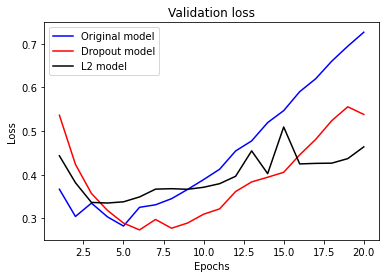

In [36]:
# 画图 Plotting the training and validation loss
import matplotlib.pyplot as plt
history_dict = history.orignal.history
val_loss_values = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

history_dict = history.L2.history
val_loss_values_L2 = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values

history_dict = history.dropout.history
val_loss_values_dropout = history_dict["val_loss"] # 提取在10,000个样品的train集上的loss values


epochs = range(1, len(loss_values) + 1) # x axis
plt.plot(epochs, val_loss_values, "b", label="Original model")
plt.plot(epochs, val_loss_values_dropout, "b",color="red", label="Dropout model")
plt.plot(epochs, val_loss_values_L2, "b",color="black", label="L2 model")


plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 总结一下，防止神经网络过拟合的常用方法包括：

1. 获取更多的训练数据    
2. 减小网络容量   
3. 添加权重正则化  
4. 添加 dropout  